In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
def ellipse_dots(a, b, samples=100, sigma=.05, angle=0): # angle in rad
    t = np.linspace(0, 2 * np.pi, samples)
    x = a * np.cos(t)
    y = b * np.sin(t)
    x_angle = x * np.cos(angle*np.pi) + y * np.sin(angle*np.pi)
    y_angle = -x * np.sin(angle*np.pi) + y * np.cos(angle*np.pi)
    return np.array((np.random.normal(x_angle, sigma), np.random.normal(y_angle, sigma)))

In [16]:
def ellipse_ransac(data, threshold_distance=0.5, threshold_inlier_count=30, max_iter=1000):
    best_ellipse = [[],0]
    for i in range(max_iter):
        ellipse = get_candidate(data, threshold_distance, threshold_inlier_count)
        if not ellipse: continue
        if ellipse[1] > best_ellipse[1]:
            best_ellipse = ellipse
    return best_ellipse

In [18]:
def get_candidate(data, threshold_distance, threshold_inlier_count):
    dots_indices = np.random.randint(0, data.shape[1], size=5)
    dots = data[:, dots_indices]

    SLAU = np.array((dots[0] ** 2, 2 * dots[1] * dots[0], dots[1] ** 2, dots[0], dots[1]))
    try:
        coefs = np.append(np.linalg.solve(SLAU.T, -np.ones_like(dots[0])),1)
    except np.linalg.LinAlgError: return   # singular matrix 
    if invariant_check(coefs): return   # not ellips

    Y = coefs[0]*(data[0])**2 + coefs[1]*(data[0])*(data[1])*2 +\
        coefs[2]*(data[1])**2 + coefs[3]*(data[0])*2 +\
        coefs[4]*(data[1])*2 + coefs[5]

    dots_inlier_indices = np.nonzero(np.abs(Y)<threshold_distance)[0]
    if dots_inlier_indices.shape[0] < threshold_inlier_count: return 
    return coefs, dots_inlier_indices.shape[0]


In [5]:
def invariant_check(coefs):
    I1 = coefs[0] + coefs[2]
    I2 = coefs[0] * coefs[2] - coefs[1] ** 2
    I3 = np.linalg.det([[coefs[0], coefs[1], coefs[3]],
                        [coefs[1], coefs[2], coefs[4]],
                        [coefs[3], coefs[4], coefs[5]]])
    return 0 if (I2 > 0) and (I1*I3<0) else 1

Best equation:
-0.024811884361590233(x-50)^2 + 0.014649782201226856(x-50)(y-30) + -0.027017045911762183(y-30)^2 + 0.0012413243908701978(x-50) + -0.004343181047083089(y-30)+ 1.0 = 0
Inliers:98
Outliers:2


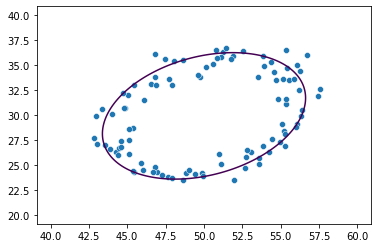

In [60]:
a = 5
b = 7
x0 = 50
y0 = 30
samples=100

y = np.linspace(y0-(a+b)/1.1, y0+(a+b)/1.1, 1000)
x = np.linspace(x0-(a+b)/1.1, x0+(a+b)/1.1, 1000)
x,y = np.meshgrid(x,y)

data = ellipse_dots(a=a, b=b, samples=samples, sigma=0.7, angle=0.25)
coefs = ellipse_ransac(data, threshold_distance=0.56, threshold_inlier_count=50, max_iter=1000)
data[0] += x0
data[1] += y0
Y = coefs[0][0]*(x-x0)**2 + coefs[0][1]*(x-x0)*(y-y0)*2 + coefs[0][2]*(y-y0)**2 + coefs[0][3]*(x-x0)*2 + coefs[0][4]*(y-y0)*2 + coefs[0][5]

print(f"Best equation:\n{coefs[0][0]}(x-{x0})^2 + {coefs[0][1]*2}(x-{x0})(y-{y0}) + {coefs[0][2]}(y-{y0})^2 + {coefs[0][3]*2}(x-{x0}) + {coefs[0][4]*2}(y-{y0})+ {coefs[0][5]} = 0\nInliers:{coefs[1]}\nOutliers:{samples-coefs[1]}")
sns.scatterplot(x=data[0], y=data[1])
plt.contour(x,y,Y,[0])